Dataset: [Kaggle](https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024)


In [26]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


import kagglehub
beatafaron_fmcg_daily_sales_data_to_2022_2024_path = kagglehub.dataset_download('beatafaron/fmcg-daily-sales-data-to-2022-2024')

print('Data source import complete.')


Data source import complete.


In [27]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import datetime

# --- Utility Libraries ---
import warnings     # To handle warning messages
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore") # Suppress warnings for a cleaner notebook output
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fmcg-daily-sales-data-to-2022-2024/weekly_df_final_for_modeling.csv
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/FMCG_2022_2024.csv
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/df_weekly_MI-006_enriched.csv
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/batch_MI-006_2025-01-27.parquet
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/batch_MI-006_2025-01-06.parquet
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/batch_MI-006_2025-01-13.parquet
/kaggle/input/fmcg-daily-sales-data-to-2022-2024/batch_MI-006_2025-01-20.parquet


In [28]:
df = pd.read_csv(f'{beatafaron_fmcg_daily_sales_data_to_2022_2024_path}/weekly_df_final_for_modeling.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31027 entries, 0 to 31026
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sku               31027 non-null  object 
 1   week              31027 non-null  object 
 2   channel           31027 non-null  object 
 3   region            31027 non-null  object 
 4   units_sold        31027 non-null  int64  
 5   stock_available   31027 non-null  float64
 6   promotion_flag    31027 non-null  int64  
 7   price_unit        31027 non-null  float64
 8   delivery_days     31027 non-null  float64
 9   is_holiday_peak   31027 non-null  bool   
 10  week_number       31027 non-null  int64  
 11  month             31027 non-null  int64  
 12  year              31027 non-null  int64  
 13  is_holiday_week   31027 non-null  int64  
 14  is_summer         31027 non-null  int64  
 15  is_winter         31027 non-null  int64  
 16  sku_age           31027 non-null  int64 

,sku,week,channel,region,units_sold,stock_available,promotion_flag,price_unit,delivery_days,is_holiday_peak,...,is_summer,is_winter,sku_age,lifecycle_stage,lag_1,lag_2,rolling_mean_4,rolling_std_4,momentum,target_next_week
0,JU-021,2022-08-08,Discount,PL-Central,130,158.8,1,4.3820,3.000000,False,...,1,0,4,Growth,122.0,99.0,132.25,27.121640,23.0,81.0
1,JU-021,2022-08-15,Discount,PL-Central,81,149.8,0,7.6140,4.000000,False,...,1,0,5,Growth,130.0,122.0,125.00,20.704267,8.0,72.0
2,JU-021,2022-08-22,Discount,PL-Central,72,151.5,0,4.1525,2.500000,False,...,1,0,6,Growth,81.0,130.0,108.00,22.286020,-49.0,125.0
3,JU-021,2022-08-29,Discount,PL-Central,125,134.0,1,3.9400,3.166667,False,...,1,0,7,Growth,72.0,81.0,101.25,28.998563,-9.0,176.0
4,JU-021,2022-09-05,Discount,PL-Central,176,176.5,0,5.0300,4.000000,False,...,0,0,8,Growth,125.0,72.0,102.00,29.743347,53.0,172.0


In [29]:
df.isnull().sum()

,0
sku,0
week,0
channel,0
region,0
units_sold,0
stock_available,0
promotion_flag,0
price_unit,0
delivery_days,0
is_holiday_peak,0


There are no missing values so we will be moving on the next  step of label encoding some of the features, and sort the data in chronological order

In [30]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_datetime(df['week'])
df.set_index('week', inplace=True)

# Sort the data by date to ensure it's in chronological order
df.sort_index(inplace=True)


encoded_features = ['sku', 'lifecycle_stage', 'channel', 'region']

for col in encoded_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


df.info()






<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31027 entries, 2022-02-14 to 2024-12-23
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sku               31027 non-null  int64  
 1   channel           31027 non-null  int64  
 2   region            31027 non-null  int64  
 3   units_sold        31027 non-null  int64  
 4   stock_available   31027 non-null  float64
 5   promotion_flag    31027 non-null  int64  
 6   price_unit        31027 non-null  float64
 7   delivery_days     31027 non-null  float64
 8   is_holiday_peak   31027 non-null  bool   
 9   week_number       31027 non-null  int64  
 10  month             31027 non-null  int64  
 11  year              31027 non-null  int64  
 12  is_holiday_week   31027 non-null  int64  
 13  is_summer         31027 non-null  int64  
 14  is_winter         31027 non-null  int64  
 15  sku_age           31027 non-null  int64  
 16  lifecycle_stage   31027

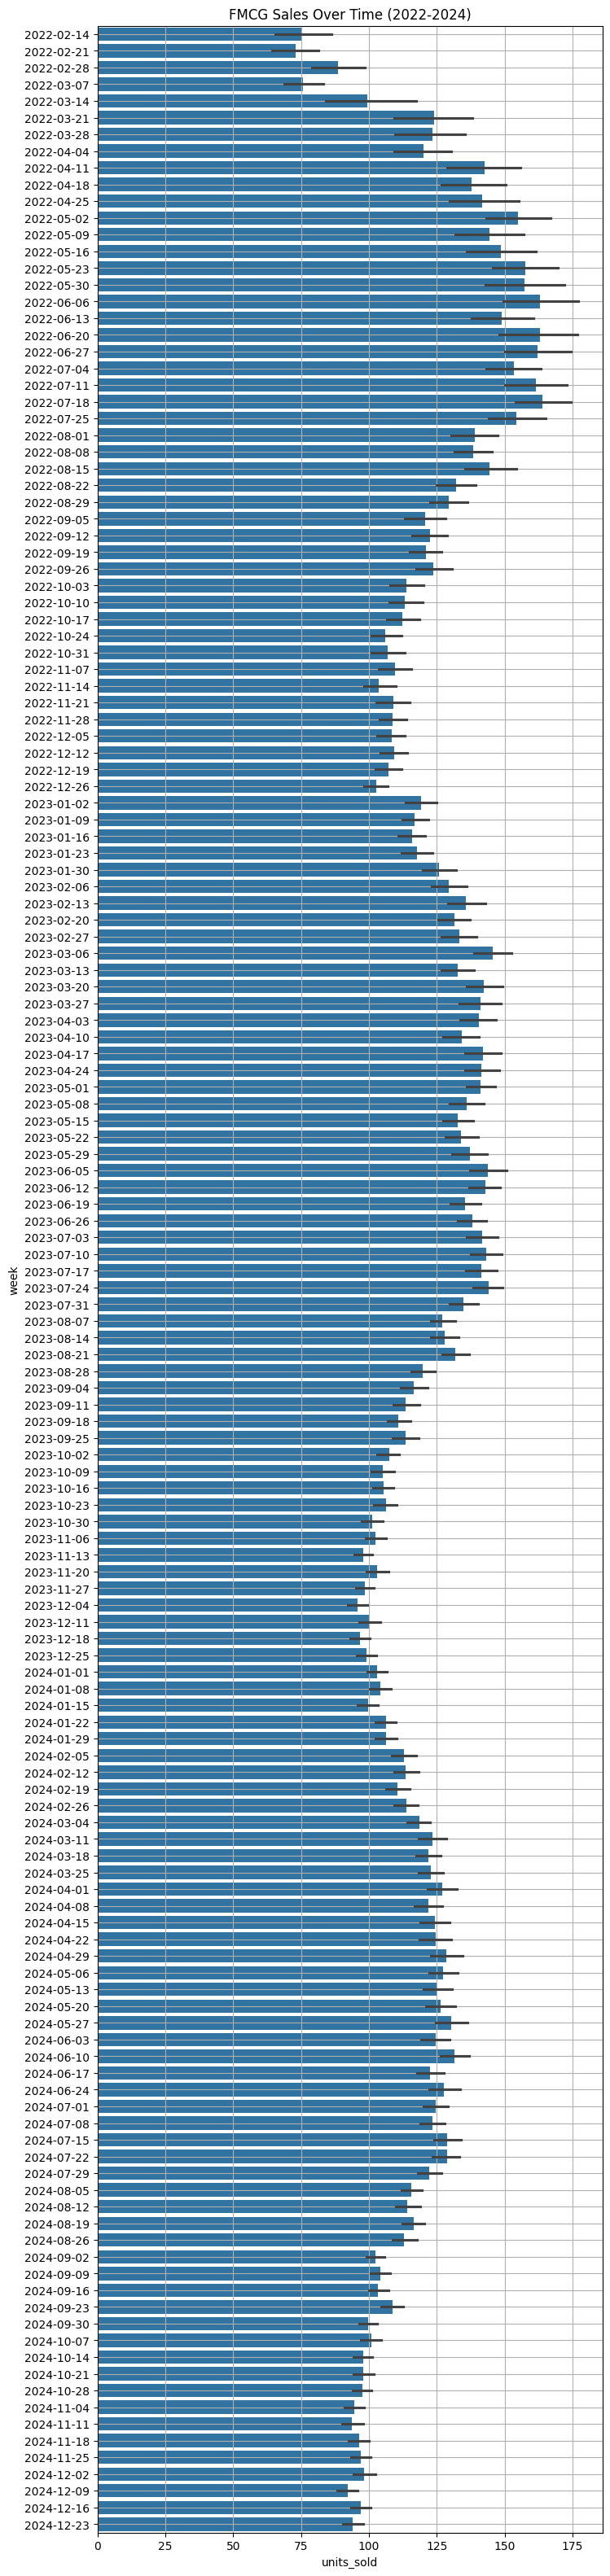

In [31]:

df = df[df['units_sold'] >= 0]


plt.figure(figsize=(8, 40))

sns.barplot(data = df, x = 'units_sold',y = 'week')

plt.title('FMCG Sales Over Time (2022-2024)')
plt.grid(True)
plt.show()


Adding some of the features to help with our prediction

In [37]:
# Create features from the datetime index
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['quarter'] = df.index.quarter





Now we split the data with 01/01/2024 as the division between the train and test dataset

In [33]:


# The target is the 'units_sold' column
y = df['units_sold']

X = df.drop('units_sold', axis=1)


X_train = X[X.index < '2024-01-01']
X_test = X[X.index >= '2024-01-01']
y_train = y[y.index < '2024-01-01']
y_test = y[y.index >= '2024-01-01']

print(f"Training set size: {len(X_train)} instances")
print(f"Testing set size: {len(X_test)} instances")

Training set size: 16996 instances
Testing set size: 14031 instances


In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sgd_model = SGDRegressor(random_state=42)
sgd_model.fit(X_train_scaled, y_train)
y_pred_sgd = sgd_model.predict(X_test_scaled)

# Evaluate SGD Model
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))
print(f"SGD - Mean Absolute Error (MAE): {mae_sgd:.2f}")
print(f"SGD - Root Mean Squared Error (RMSE): {rmse_sgd:.2f}")




SGD - Mean Absolute Error (MAE): 20.95
SGD - Root Mean Squared Error (RMSE): 27.07


In [35]:
# --- Model B: Random Forest Regressor (Recommended Model) ---
print("\n--- B. Random Forest Regressor ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose = 1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse_rf:.2f}")






--- B. Random Forest Regressor ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


Random Forest - Mean Absolute Error (MAE): 19.58
Random Forest - Root Mean Squared Error (RMSE): 25.37


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


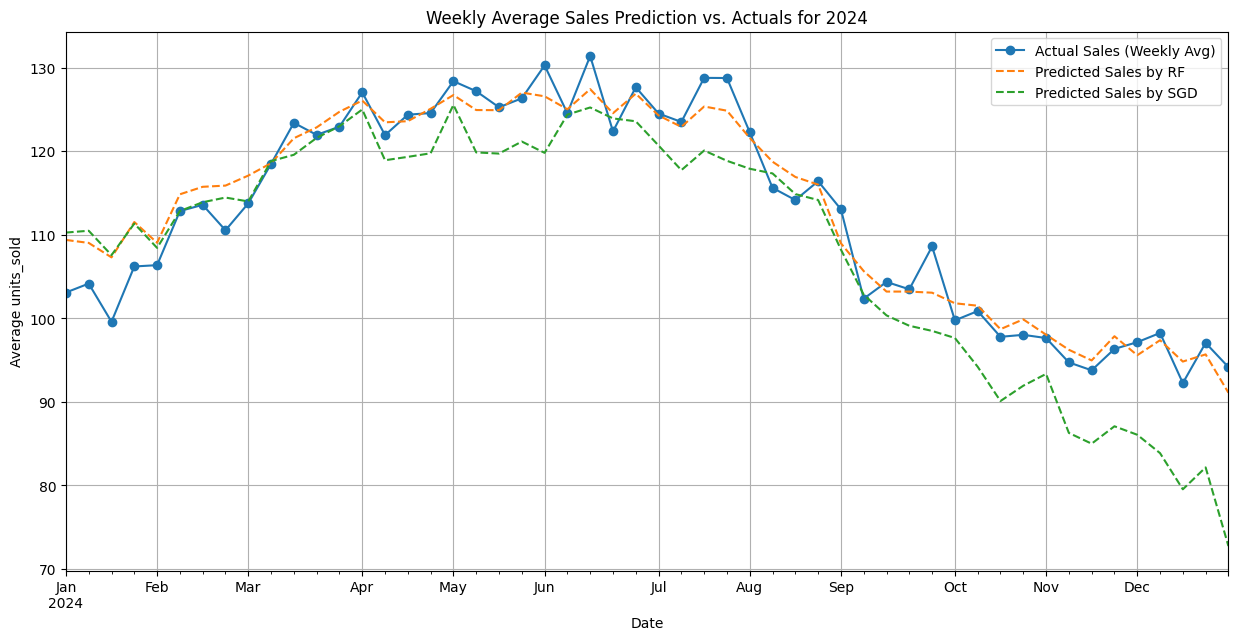

In [36]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({'Actual units_sold': y_test, 'Predicted by RF': y_pred_rf, 'Predicted by SGD': y_pred_sgd})

# Resample the data to a weekly frequency and calculate the mean
# 'W' stands for weekly. This will smooth out the daily noise.
weekly_results = results_df.resample('W').mean()

plt.figure(figsize=(15, 7))
weekly_results['Actual units_sold'].plot(label='Actual Sales (Weekly Avg)', style='-', marker='o')
weekly_results['Predicted by RF'].plot(label='Predicted Sales by RF', style='--')
weekly_results['Predicted by SGD'].plot(label='Predicted Sales by SGD', style='--')
plt.title('Weekly Average Sales Prediction vs. Actuals for 2024')
plt.xlabel('Date')
plt.ylabel('Average units_sold')
plt.legend()
plt.grid(True)
plt.show()

The prediction seems quite accurate, with the *RF* model comes ahead and outperform the *SGD* model